In [19]:
import pandas as pd


df = pd.read_csv("european_capitals_history_full.csv")


print(" Informacje o datasetcie:")
print(df.info())


print(" Liczba braków w każdej kolumnie:")
print(df.isnull().sum())


missing_by_city = df.groupby('city').apply(lambda x: x.isnull().sum())

print("Liczba braków w każdej kolumnie, podzielona na miasta:")
print(missing_by_city)

 Informacje o datasetcie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222403 entries, 0 to 222402
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    222403 non-null  object 
 1   tavg    222403 non-null  float64
 2   tmin    222290 non-null  float64
 3   tmax    222305 non-null  float64
 4   prcp    203005 non-null  float64
 5   wspd    212088 non-null  float64
 6   pres    174555 non-null  float64
 7   city    222403 non-null  object 
 8   lat     222403 non-null  float64
 9   lon     222403 non-null  float64
dtypes: float64(8), object(2)
memory usage: 17.0+ MB
None
 Liczba braków w każdej kolumnie:
date        0
tavg        0
tmin      113
tmax       98
prcp    19398
wspd    10315
pres    47848
city        0
lat         0
lon         0
dtype: int64
Liczba braków w każdej kolumnie, podzielona na miasta:
                 date  tavg  tmin  tmax  prcp  wspd  pres  city  lat  lon
city                             

C:\Users\s27753\AppData\Local\Temp\ipykernel_10452\191479216.py:15: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [30]:
import pandas as pd

#  Wczytanie danych
df = pd.read_csv("european_capitals_history_full.csv")

# Kolumny meteorologiczne do uzupełnienia
weather_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']

# ⃣ Grupowanie po mieście i wypełnianie braków
df_clean = df.groupby('city').apply(
    lambda x: x[weather_cols].interpolate(method='linear').ffill().bfill()
)

# Przywrócenie kolumn meta (date, lat, lon)
meta_cols = ['date', 'city', 'lat', 'lon']
df_meta = df[meta_cols].reset_index(drop=True)
df_clean = df_clean.reset_index(drop=True)
df_final = pd.concat([df_meta, df_clean], axis=1)

#  Sprawdzenie braków po czyszczeniu
print(" Braki danych po wypełnieniu:")
print(df_final.isnull().sum())

df_final['tavg_rolling3'] = df.groupby('city')['tavg'].transform(lambda x: x.rolling(3).mean())
df_final['tavg_diff1'] = df.groupby('city')['tavg'].diff()

df_final = df_final.dropna(subset=['tavg_rolling3', 'tavg_diff1']).reset_index(drop=True)


#  Zapis do nowego CSV
df_final.to_csv("european_capitals_history_clean.csv", index=False)
print(" Czysty dataset zapisany: european_capitals_history_clean.csv")


C:\Users\s27753\AppData\Local\Temp\ipykernel_10452\3407122930.py:10: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



 Braki danych po wypełnieniu:
date    0
city    0
lat     0
lon     0
tavg    0
tmin    0
tmax    0
prcp    0
wspd    0
pres    0
dtype: int64
 Czysty dataset zapisany: european_capitals_history_clean.csv


In [27]:
cols = ['tavg','tmin','tmax','prcp','wspd','pres']
for col in cols:
    q1 = df_final[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df_final[col] = df_final[col].clip(lower=q1, upper=q99)


In [23]:
print(df_final.isnull().sum())

date             0
city             0
lat              0
lon              0
tavg             0
tmin             0
tmax             0
prcp             0
wspd             0
pres             0
tavg_rolling3    0
tavg_diff1       0
dtype: int64


Podstawowe informacje o datasetcie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222323 entries, 0 to 222322
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           222323 non-null  object 
 1   city           222323 non-null  object 
 2   lat            222323 non-null  float64
 3   lon            222323 non-null  float64
 4   tavg           222323 non-null  float64
 5   tmin           222323 non-null  float64
 6   tmax           222323 non-null  float64
 7   prcp           222323 non-null  float64
 8   wspd           222323 non-null  float64
 9   pres           222323 non-null  float64
 10  tavg_rolling3  222323 non-null  float64
 11  tavg_diff1     222323 non-null  float64
dtypes: float64(10), object(2)
memory usage: 20.4+ MB
None

Opis statystyczny danych meteorologicznych:
                tavg           tmin           tmax           prcp  \
count  222323.000000  222323.000000  222323.000000

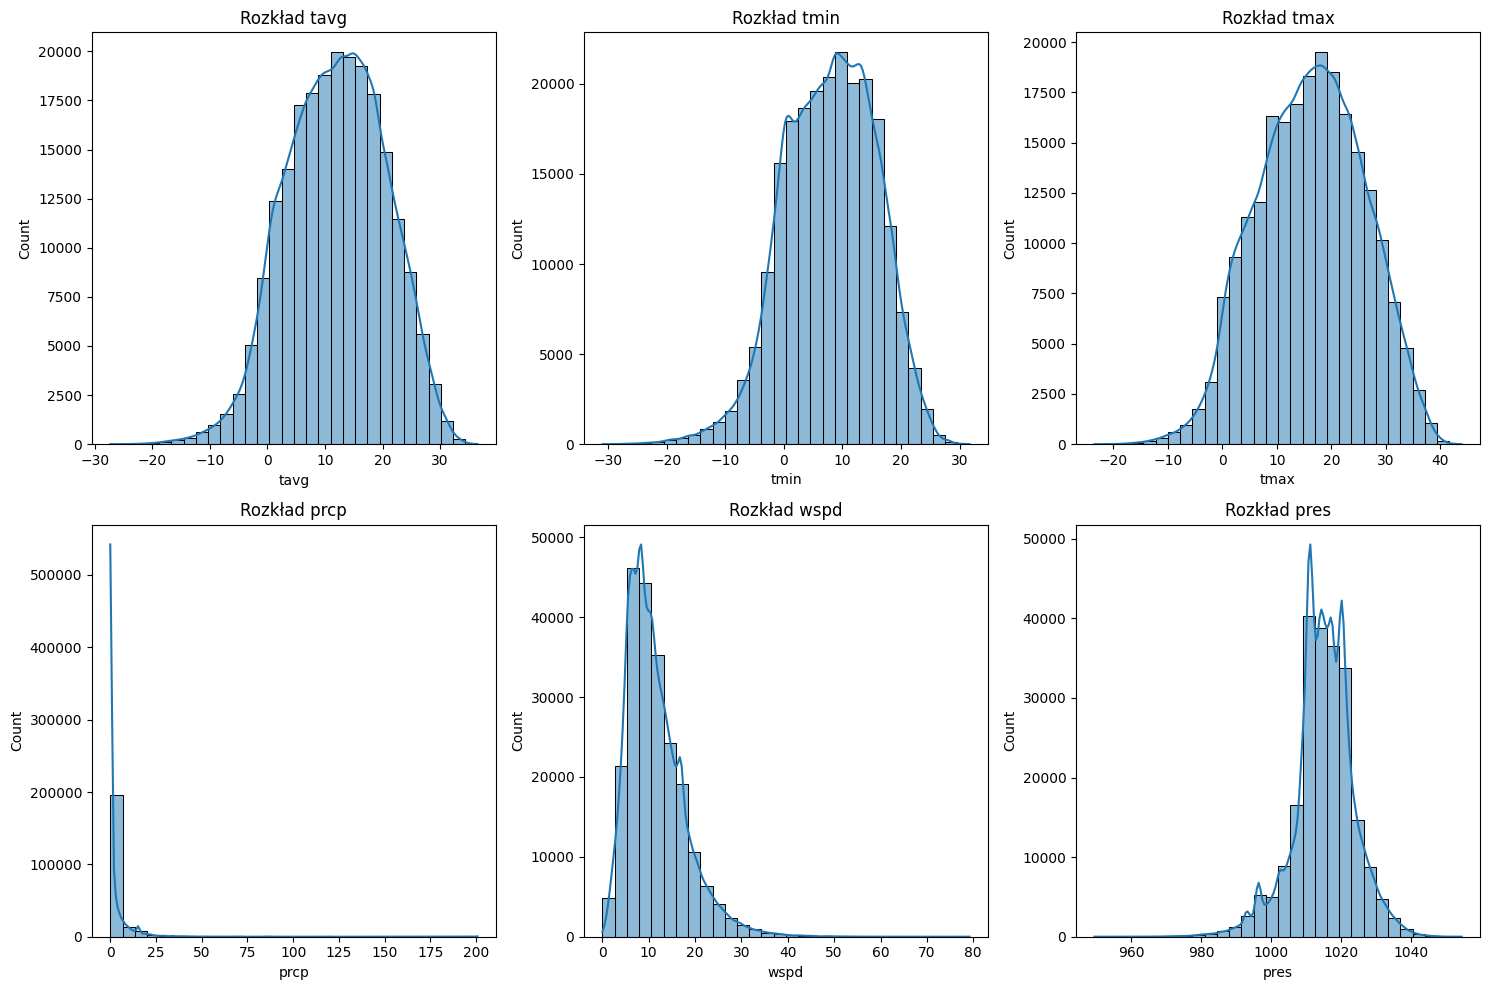

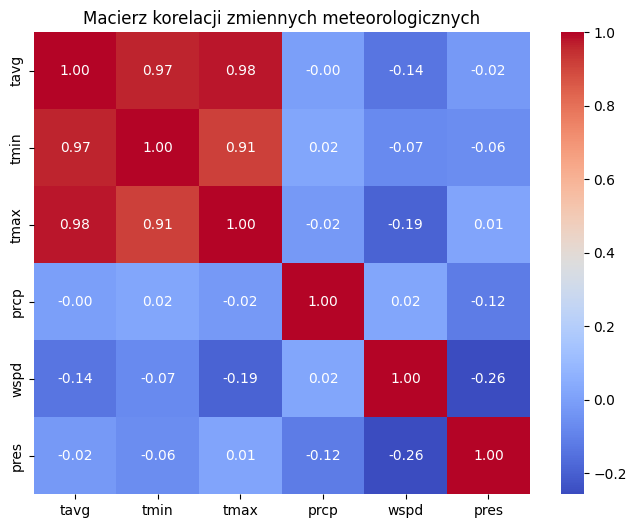

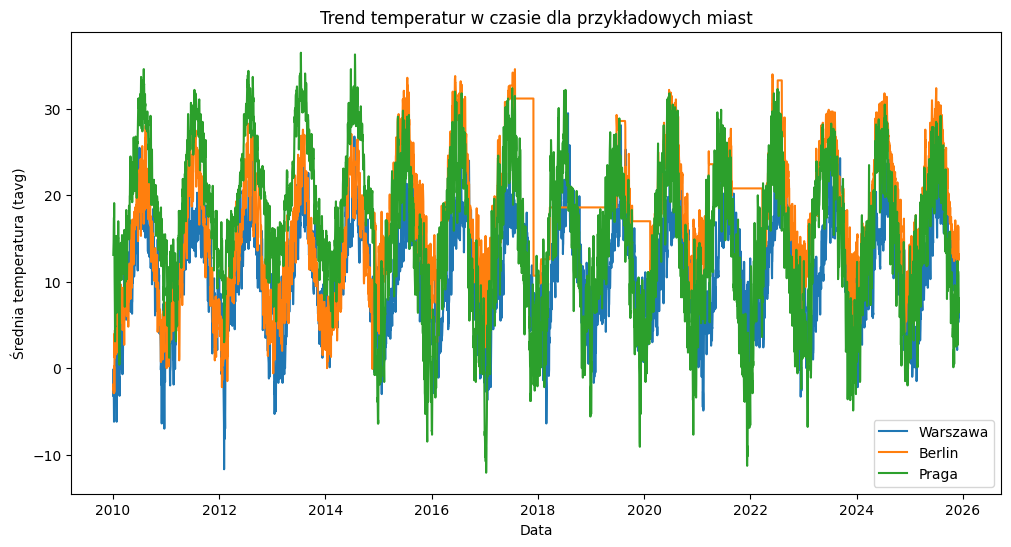

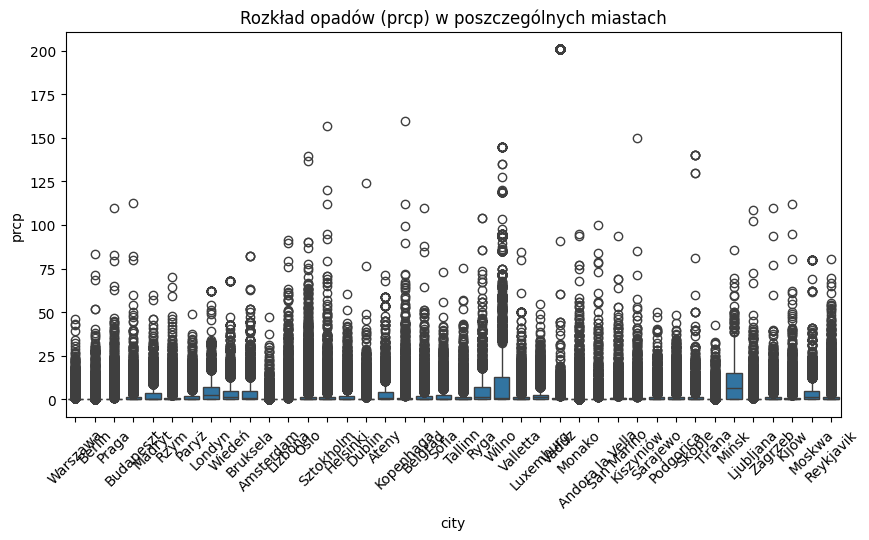

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie wyczyszczonego datasetu
df = pd.read_csv("european_capitals_history_clean.csv")

# --- Podstawowa analiza statystyczna ---
print("Podstawowe informacje o datasetcie:")
print(df.info())
print("\nOpis statystyczny danych meteorologicznych:")
print(df[['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']].describe())

# --- Liczba wpisów na miasto ---
print("\nLiczba wpisów dla każdego miasta:")
print(df['city'].value_counts())

# --- Wizualizacja rozkładów danych ---
weather_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']

plt.figure(figsize=(15,10))
for i, col in enumerate(weather_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Rozkład {col}')
plt.tight_layout()
plt.show()

# --- Korelacja między zmiennymi meteorologicznymi ---
corr = df[weather_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji zmiennych meteorologicznych')
plt.show()

# --- Trend temperatur w czasie dla przykładowych miast ---
sample_cities = df['city'].unique()[:3]  # przykładowe 3 miasta
plt.figure(figsize=(12,6))
for city in sample_cities:
    city_data = df[df['city']==city]
    plt.plot(pd.to_datetime(city_data['date']), city_data['tavg'], label=city)
plt.xlabel('Data')
plt.ylabel('Średnia temperatura (tavg)')
plt.title('Trend temperatur w czasie dla przykładowych miast')
plt.legend()
plt.show()

# --- Analiza opadów ---
plt.figure(figsize=(10,5))
sns.boxplot(x='city', y='prcp', data=df)
plt.xticks(rotation=45)
plt.title('Rozkład opadów (prcp) w poszczególnych miastach')
plt.show()


In [25]:
import plotly.express as px
df_avg = df.groupby(['city', 'lat', 'lon'], as_index=False)['tavg'].mean()

# Mapa punktowa
fig = px.scatter_geo(
    df_avg,
    lat='lat',
    lon='lon',
    color='tavg',
    size='tavg',
    hover_name='city',
    projection='natural earth',
    color_continuous_scale='RdYlBu_r',
    title='Średnia temperatura w miastach'
)

fig.update_layout(geo=dict(showland=True, landcolor="lightgray"))
fig.show()